# STUDENT - what is going on below?

You need to read this Notebook and assume that a colleague has asked you for a code review. What is potentially most damaging to their ongoing productivity and correctness? 

* Are there examples of unnecessary repetition?
* Are there bad naming standards which makes the code look "non-Pythonic"?
* Can you interpret their method and results clearly?

----

# Analysis of household air-moisture levels

As part of an ongoing analysis to derive metadata from a timeseries we're using some household data at the 1 minute level to display temperature & humidity levels in our house in 2 rooms.

We then back-calculate the moisture level (grams per metre cubed) for the actual amount of water in a cubed meter or air near the sensor, to get an understanding of where the most or least water is in the house and which household events affect these levels.

We can use similar processes to derive signals for work-releated problems on our own timeseries data, this analysis combines both work and play and will be used as an internal proof-of-concept to get sign-off from the team for running a similar project on internal business data.

**GOAL FOR THIS NOTEBOOK - can we determine that we _can_ identify a change in moisture levels for data from two different rooms?**

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np

df = pd.read_csv('Kitchen_export_202112311652.csv', parse_dates=True)

# check for the badness from data supplier
# we check that these columns are hard to read (that's the supplier's fault!)
assert df.columns[0] == 'Timestamp\xa0for\xa0sample\xa0frequency\xa0every\xa01 min\xa0min'
assert df.columns[1] == ' Temperature_Celsius'
assert df.columns[2] == 'Relative_Humidity'

# and then we can rename the columns to something sane
df.columns = ['timestamp', 't_c', 'rh']

df['timestamp'] = pd.to_datetime(df.reset_index()['timestamp'])

#df = df.set_index('timestamp')
df.set_index('timestamp', inplace=True)
print(f"Date range {df.index.min()} - {df.index.max()}")

# now let's choose a day
day_to_choose = '2021-12-24'
print(f"Working on {day_to_choose}")
assert pd.to_datetime(day_to_choose) > df.index.min(), "Must be in date range"
assert pd.to_datetime(day_to_choose) < df.index.max(), "Must be in date range"

df
# Tidy up the dataframe...BUT IT DOESN'T WORK
#renames = {'Timestamp for sample frequency every 1 min min': 'timestamp'}
#df.rename(columns=renames).head()

Date range 2021-12-22 17:00:00 - 2021-12-31 16:52:00
Working on 2021-12-24


,t_c,rh
timestamp,,
2021-12-22 17:00:00,14.0,48.1
2021-12-22 17:01:00,14.0,48.2
2021-12-22 17:02:00,14.0,48.1
2021-12-22 17:03:00,14.0,48.1
2021-12-22 17:04:00,14.0,48.2
...,...,...
2021-12-31 16:48:00,18.4,71.2
2021-12-31 16:49:00,18.4,70.7
2021-12-31 16:50:00,18.4,70.4


In [32]:
dfh = df.resample('30min').mean()
dfh.tail(5)

,t_c,rh
timestamp,,
2021-12-31 14:30:00,18.393333,68.936667
2021-12-31 15:00:00,18.300000,68.963333
2021-12-31 15:30:00,18.230000,68.300000
2021-12-31 16:00:00,18.266667,69.536667
2021-12-31 16:30:00,18.378261,71.147826


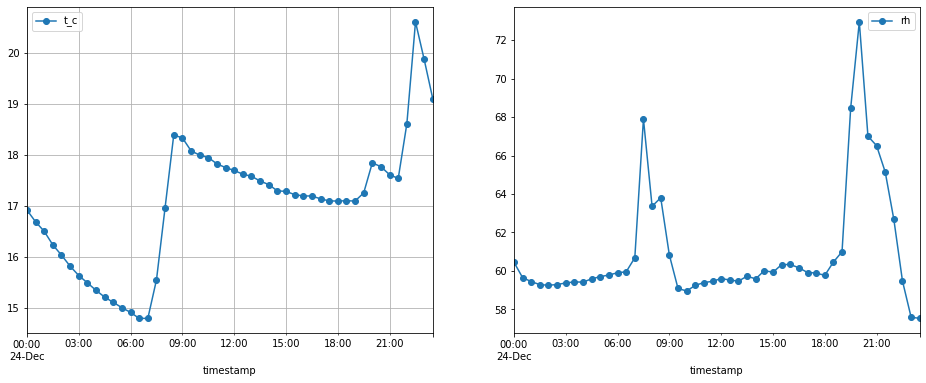

In [33]:
dfx = dfh.loc[day_to_choose].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
dfx.plot(x='timestamp', y='t_c', marker='o', ax=axs[0])
dfx.plot(x='timestamp', y='rh', marker='o', ax=axs[1])
axs[0].grid(which='both')

In [34]:
# saturation pressure
# ps = 610.78 *exp( t / ( t + 238.3 ) *17.2694 ) 
# via https://www.conservationphysics.org/atmcalc/atmoclc1.html
# TODO this won't work for negative values, we should probably warn my future self
ts = np.arange(0, 31, 0.1)
satp = 610.78 *np.exp(ts/(ts+38.3) * 17.2694)

max_water_gm3_at_temp = 0.002166 *satp / ( ts + 273.16 ) * 1000
max_water_gm3_at_temp[:5]
df_moisture = pd.DataFrame({'t_c': ts, 
                            'max_water_gm3': max_water_gm3_at_temp})
df_moisture = df_moisture.set_index('t_c')
df_moisture.head()

,max_water_gm3
t_c,
0.0,4.843130
0.1,5.064056
0.2,5.293822
0.3,5.532732
0.4,5.781095


In [23]:

df_hw = pd.merge_asof(dfh.sort_values('t_c'), df_moisture, left_on='t_c', right_index=True).sort_index()
df_hw.head(2)

,t_c,rh,max_water_gm3
timestamp,,,
2021-12-22 17:00:00,13.916667,48.226667,457.823816
2021-12-22 17:30:00,13.756667,48.800000,436.351180


<AxesSubplot:xlabel='timestamp'>

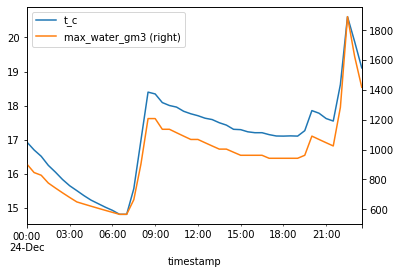

In [24]:
df_hw.loc[day_to_choose][['t_c', 'max_water_gm3']].plot(secondary_y=['max_water_gm3'])

<AxesSubplot:xlabel='timestamp'>

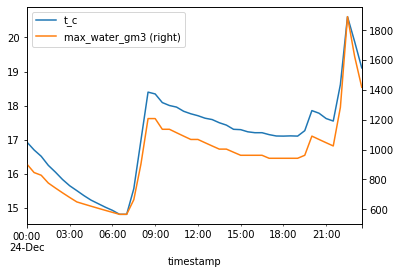

In [25]:
df_hw.loc[day_to_choose][['t_c', 'max_water_gm3']].plot(secondary_y=['max_water_gm3'])

In [26]:
df_hw['est_water_gm3'] = df_hw['max_water_gm3'] * df_hw['rh'] / 100
df_hw.head(2)

,t_c,rh,max_water_gm3,est_water_gm3
timestamp,,,,
2021-12-22 17:00:00,13.916667,48.226667,457.823816,220.793166
2021-12-22 17:30:00,13.756667,48.800000,436.351180,212.939376


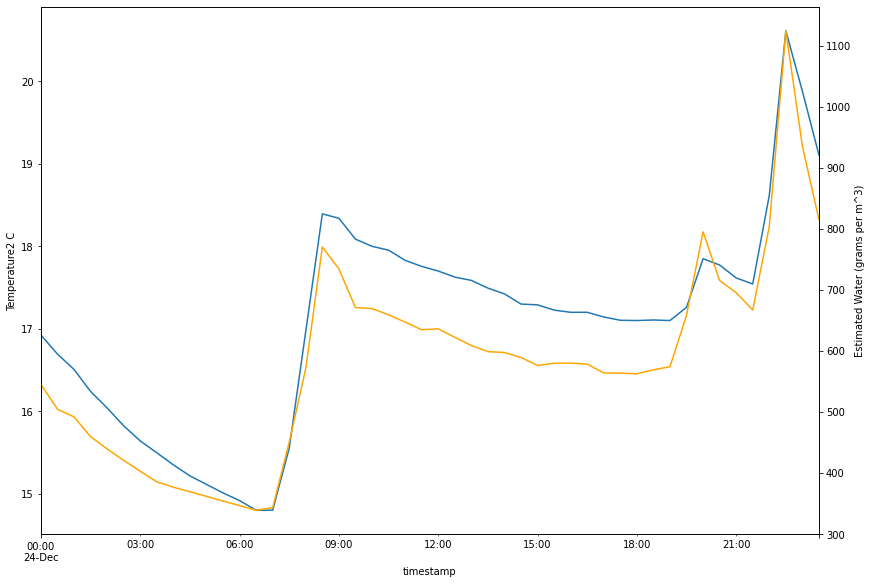

In [27]:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
# the above will fix the double-legend outcome

fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 8))

#nbr_hours = 24 * 5
dfx = df_hw.loc[day_to_choose]
dfx['t_c'].plot(ylabel='Temperature C', ax=ax)
ax2=dfx['est_water_gm3'].plot(secondary_y=True, ylabel='Temperature2 C', c='orange')
ax2.set_ylabel('Estimated Water (grams per m^3)')
#ax.set_title('Estimated moisture in house air');
title=f'Estimated moisture in house air\n'
#ax.legend();
#set_common_mpl_styles(ax, grid_axis='both', title=title)
#set_common_mpl_styles(ax2, grid_axis=None)
#ax.yaxis.get_ticklocs(minor=True).minorticks_on()
#ax.yaxis.grid(True, which='minor')

# Monte carlo sampling for temperatures

In [10]:
import numpy as np

In [11]:
t = df['t_c'].values

In [12]:
def make_bootstrap(n, t):
    for n in range(100):
        mask = np.random.randint(0, t.shape, t.shape)
        bootstrp_sample = t[mask]
        bootstrap_statistics.append(bootstrap_sample.mean())

    bootstrap_statistics = sorted(bootstrap_statistics)
    bootstrap_statistics = np.array(bootstrap_statistics)
    return bootstrap_statistics

In [13]:
import numpy as np
from pandas import *

bootstrap_statistics = []
for n in range(100):
    mask = np.random.randint(0, t.shape, t.shape)
    bootstrap_sample = t[mask]
    bootstrap_statistics.append(bootstrap_sample.mean())
    
bootstrap_statistics = sorted(bootstrap_statistics)
bootstrap_statistics = np.array(bootstrap_statistics)
pc_25th_idx = int(bootstrap_statistics.shape[0] * 0.05)
pc_50th_idx = int(bootstrap_statistics.shape[0] * 0.5)
pc_75th_idx = int(bootstrap_statistics.shape[0] * 0.95)
pc_25th = bootstrap_statistics[pc_25th_idx]
pc_50th = bootstrap_statistics[pc_50th_idx]
pc_75th = bootstrap_statistics[pc_75th_idx]

## Typical room temperature

We can use bootstrapping to estimate a confidence interval on the 1-minute original data to get a 95% CI around the mean temperature for the week or so of data we have. I don't know if we have a normal distribution for temperatures so I figured a bootstrap estimate was safer.

For the kitchen the typical room temperature is around $16.90-16.93^oC$, for the first floor hall. For the kitchen it is typically between $16.88-16.92^oC$. 

Text(0.5, 1.0, 'Distribution of 100 bootstrap means with\nmedian 16.901$^\\circ C$ (16.883$^\\circ C$ - 16.922$^\\circ C$ 90% CI)')

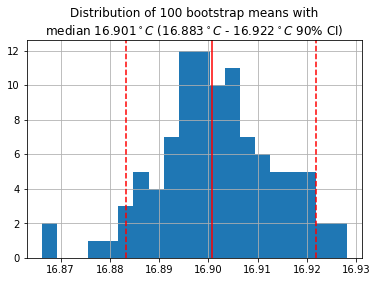

In [14]:
df_means = pd.DataFrame(bootstrap_statistics, columns=['means'])
ax = df_means.hist(bins=20)[0][0]
ax.axvline(pc_25th, c='r', linestyle='--')
ax.axvline(pc_50th, c='r')
ax.axvline(pc_75th, c='r', linestyle='--')
title = f'Distribution of {bootstrap_statistics.shape[0]:,} bootstrap means with'
title += f'\nmedian {pc_50th:0.3f}$^\circ C$ ({pc_25th:0.3f}$^\circ C$ - {pc_75th:0.3f}$^\circ C$ 90% CI)'
ax.set_title(title)

# Do same again for the hallway

In [15]:
df = pd.read_csv("First floor hall_export_202112311700.csv", parse_dates=True)

# check for the badness
assert df.columns[0] == 'Timestamp\xa0for\xa0sample\xa0frequency\xa0every\xa01 min\xa0min'
assert df.columns[1] == ' Temperature_Celsius'
assert df.columns[2] == 'Relative_Humidity'

df.columns = ['timestamp', 't_c', 'rh']

df['timestamp'] = pd.to_datetime(df.reset_index()['timestamp'])

df = df.set_index('timestamp')
print(f"Date range {df.index.min()} - {df.index.max()}")

print(f"Working on {day_to_choose}")
assert pd.to_datetime(day_to_choose) > df.index.min(), "Must be in date range"
assert pd.to_datetime(day_to_choose) < df.index.max(), "Must be in date range"

Date range 2021-12-22 17:00:00 - 2021-12-31 17:00:00
Working on 2021-12-24


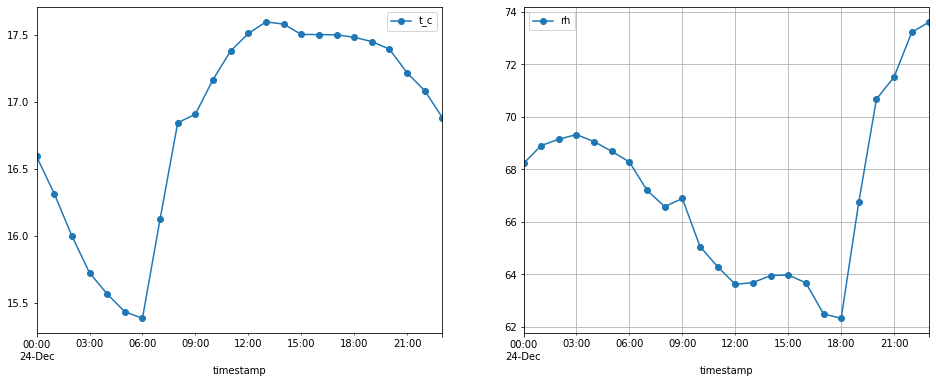

In [16]:
dfh = df.resample('1h').mean()
dfx = dfh.loc[day_to_choose].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
dfx.plot(x='timestamp', y='t_c', marker='o', ax=axs[0])
dfx.plot(x='timestamp', y='rh', marker='o', ax=axs[1])
axs[1].grid(which='both')

In [17]:
df_hw = pd.merge_asof(dfh.sort_values('t_c'), df_moisture, left_on='t_c', right_index=True).sort_index()
df_hw['est_water_gm3'] = df_hw['max_water_gm3'] * df_hw['rh'] / 100

df_hw.head(2)

,t_c,rh,max_water_gm3,est_water_gm3
timestamp,,,,
2021-12-22 17:00:00,16.00000,54.620000,741.910138,405.231317
2021-12-22 18:00:00,16.02069,53.898276,741.910138,399.876773


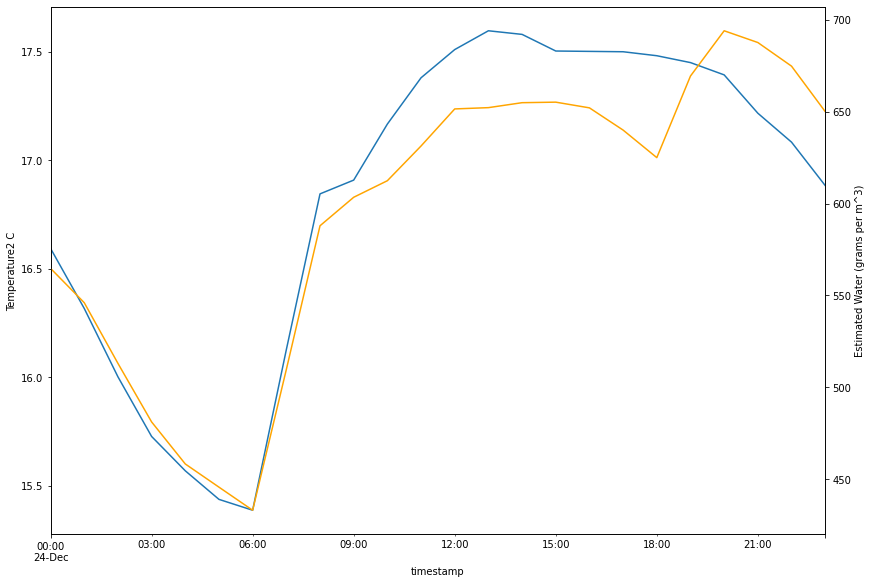

In [18]:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
# the above will fix the double-legend outcome

fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 8))

#nbr_hours = 24 * 5
dfx = df_hw.loc[day_to_choose]
dfx['t_c'].plot(ylabel='Temperature C', ax=ax)
ax2=dfx['est_water_gm3'].plot(secondary_y=True, ylabel='Temperature2 C', c='orange')
ax2.set_ylabel('Estimated Water (grams per m^3)')
#ax.set_title('Estimated moisture in house air');
title=f'Estimated moisture in house air\n'
#ax.legend();
#ax.yaxis.get_ticklocs(minor=True).minorticks_on()
#ax.yaxis.grid(True, which='minor')

# Conclusion

We can see that on the 24th December we were absent from the house during the middle of the day.

* 6.30am the heating comes on and the temperature rises
* 8am we make tea and get son up, releative humidity rises and the moisture content of the air increases
* 9-5pm we're away, the heating is on but nothing adds water into the air as we're absent
* 6pm we get home
* 7pm bath run for the infant (bathroom next to first floor sensor) and humidifier on the first floor turned on both of which add moisture to air, the humidifer runs for 17 hours keeping moisture levels high on the landing on the first floor
* 8pm we cook rice in a pan in the kitchen which adds moisture

In [ ]:
def print(p):
    """Simple way to add datetime to a print"""
    import datetime
    print((datetime.datetime.now(), p))